In [2]:
from jax import config
config.update("jax_enable_x64", True)  

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from itertools import product
import pickle
from functools import partial
import skgeom as sg

from olympus.event_generation.detector import make_triang, make_hex_grid, Detector

from olympus.event_generation.utils import sph_to_cart_jnp
from olympus.event_generation.constants import Constants
from jax import vmap, jit
from jax import numpy as jnp
import scipy.stats
import jax 

In [3]:
def tau_prop_dist(energy):
    tau_mass = 1.77686
    tau_tau = 290.3E-15
    gamma = energy / tau_mass

    return tau_tau * gamma * Constants.c_vac * 1E9




In [4]:
tau_prop_dist(1E4)

0.48979520365926404

In [5]:
def inv_fisher(series, counts_only):
    stacked = np.stack(series.values, axis=0)
    if counts_only:
        stacked = np.delete(stacked, 5, axis=1)
        stacked = np.delete(stacked, 5, axis=2)
    inv = np.linalg.inv(stacked)
    return inv

def cramer_rao_std(series):    
    cr = np.diag(np.sqrt(np.average(series, axis=0)))
    return cr

def cramer_rao(fisher, counts_only):

    if counts_only:
        fisher = np.delete(fisher, 5, axis=0)
        fisher = np.delete(fisher, 5, axis=1)

    try:
        inv = np.linalg.inv(fisher)
        cr = np.diag(np.sqrt(inv))
       
    except np.linalg.LinAlgError:
        cr = np.zeros_like(fisher)

    return cr

def check_in_volume(df, cluster):

    df = df.reset_index()

    det_polys = {}
    for spacing in df.spacing.unique():
        if cluster:
            det = Detector(make_hex_grid(3, spacing, 1, 1, truncate=1))
        else:
            det = make_triang(spacing, 1, 1)
        chull_points = sg.convex_hull.graham_andrew([sg.Point2(*c) for c in det.module_coords[:, [0, 1]]])
        chull_poly = sg.Polygon(chull_points)
        det_polys[spacing] = chull_poly
    
    is_in = []
    for pos, spacing in zip(df["pos"].values, df["spacing"].values):
        poly = det_polys[spacing]
        p = sg.Point2(pos[0], pos[1])
        is_in.append(poly.oriented_side(p) == poly.orientation())
    return is_in



def angdist(theta, phi, theta2, phi2):
    dir1 = sph_to_cart_jnp(theta, phi)
    dir2 = sph_to_cart_jnp(theta2, phi2)

    return jnp.arccos(jnp.dot(dir1, dir2))
dpsi_jit = jit(vmap(angdist, in_axes=[None, None, 0, 0]))


def dpos(x, y, z, x2, y2, z2):
    separation = jnp.linalg.norm(jnp.asarray([x, y, z]) - jnp.asarray([x2, y2, z2]))
    return separation


dpos_jac = jax.jacfwd(dpos, argnums = [0, 1, 2, 3, 4, 5])

@jax.jit
def dpos_uncert(x, y, z, x2, y2, z2, fisher):
    jacobian = jnp.stack(dpos_jac(x, y, z, x2, y2, z2))
    uncert = jnp.linalg.inv(fisher)[[0, 1, 2, 8, 9, 10], :][..., [0, 1, 2, 8, 9, 10]]
    return jnp.sqrt(jacobian.T @ uncert @ jacobian)

@jax.jit
def pos_uncert(pos, fisher):
    jacobian = jax.jacfwd(jnp.linalg.norm)(pos)
    uncert = jnp.linalg.inv(fisher)[[0, 1, 2], :][..., [0, 1, 2]]
    return jnp.sqrt(jacobian.T @ uncert @ jacobian)

def calc_pos_uncert(df):
    uncerts = []
    for _, row in df.iterrows():    

        position = row["pos"]
        uncerts.append(np.asarray(pos_uncert(position, row["fisher"])))
    df["pos_uncert"] = uncerts
    return df



def calc_separation_uncert(df):
    uncerts = []
    for _, row in df.iterrows():    

        position = row["pos"]
        position2 = row["pos"] + row["separation"] * sph_to_cart_jnp(row["theta"], row["phi"])

        uncerts.append(dpos_uncert(position[0], position[1], position[2], position2[0], position2[1], position2[2], row["fisher"]))
    df["sep_uncert"] = uncerts
    return df


def read_data(fname, varnames):

    counts_only = "counts_only" in fname
    cluster = "cluster" in fname

    df = pd.DataFrame(pickle.load(open(fname, "rb")))
    if "pos" not in df:
        df["pos"] = df["position"]
    df["rho"] = df["pos"].apply(lambda s: np.sqrt(s[0]**2 + s[1]**2))
    df["contained"] = check_in_volume(df, cluster)

    dangle_dists = []
    angs = df[["theta", "phi"]].values
    cr = np.stack(df["fisher"].apply(np.linalg.inv))
    covs = cr[:, [3, 4], :][..., [3, 4]]

    for ang, cov in zip(angs, covs):

        if not np.all(np.diag(cov) > 0):
            dangle_dists.append([])
            continue

        try: # Cholesky decomposition fails for matrices that are NOT positive definite.

            # But since the matrix may be positive SEMI-definite due to rank deficiency
            # we must regularize.
            regularized_X = cov + np.eye(cov.shape[0]) * 1e-14

            np.linalg.cholesky(regularized_X)

            rec_angle = scipy.stats.multivariate_normal.rvs(mean=ang, cov=cov, size=1000)
    
        except:
           
            rec_theta = np.random.normal(ang[0], cov[0, 0], size=1000)
            rec_phi = np.random.normal(ang[1], cov[1, 1], size=1000)

            rec_angle = jnp.stack([rec_theta, rec_phi])

        dangles = dpsi_jit(ang[0], ang[1], rec_angle[:, 0], rec_angle[:, 1])
        dangle_dists.append(dangles)
    df["dangle_dists"] = dangle_dists
    df["dangle_dists_mean"] = df["dangle_dists"].apply(np.average)
    df = calc_pos_uncert(df)

       
    iff_avg = partial(inv_fisher, counts_only=counts_only)
    ifcr = partial(cramer_rao, counts_only=counts_only)

    grouped = df.loc[df["contained"]].groupby(["spacing", "energy", "pmts"])
    cr = grouped.fisher.agg(iff_avg)    
    cr_avg = np.vstack(cr.agg(cramer_rao_std).values)
    cr_avg_d = {varnames[i]: cr_avg[:, i] for i in range(len(varnames))}

    def concavg(s):
        avg = np.average(np.concatenate(s.values))
        return avg

    cr_avg_d["ang_res_sampl"] = np.degrees(grouped.dangle_dists.agg(concavg))

    cr_avg_df = pd.DataFrame(cr_avg_d, index=cr.index)
    cr_avg_df["theta_deg"] = np.degrees(cr_avg_df["stheta"])
    cr_avg_df["phi_deg"] = np.degrees(cr_avg_df["sphi"])

    cr_avg_df["ang_res_circ"] = np.degrees(np.sqrt(cr_avg_df["sphi"]**2 + cr_avg_df["stheta"]**2))

    cr_df = np.stack(df.fisher.apply(ifcr).values)

    for i in range(len(varnames)):
        df[varnames[i]] = cr_df[:, i]
    df["invfisch"] = df.fisher.apply(ifcr)

    return cr_avg_df, df.set_index(["spacing", "energy", "pmts"])






In [6]:
rng_theta = np.arccos(np.random.uniform(-1, 1, size=1000))
rng_phi = np.random.uniform(0, 2*np.pi, size=1000)

dir = sph_to_cart_jnp(rng_theta, rng_phi)
dpsi = jit(vmap(vmap(angdist, in_axes=[0, 0, None, None]), in_axes=[None, None, 0, 0]))(rng_theta, rng_phi, rng_theta, rng_phi)


2022-04-04 11:33:45.992452: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11/lib64/:/opt/LeptonInjector/install:/usr/local/cuda-11/lib64/:/usr/local/nvidia/lib:/usr/local/nvidia/lib64/
2022-04-04 11:33:45.992541: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
dpsi = dpsi.ravel()
np.degrees(np.mean(dpsi[(dpsi != 0) & np.isfinite(dpsi)]))

89.86118146764653

In [8]:
varnames_casc_counts = ["x", "y", "z", "stheta", "sphi", "logE"]
varnames_casc = ["x", "y", "z", "stheta", "sphi", "t", "logE"]
varnames_double_casc = ["x", "y", "z", "stheta", "sphi", "t", "logE", "logE2", "logseparation"]
varnames_double_casc_new = ["x", "y", "z", "stheta", "sphi", "t", "logE", "logE2", "x2", "y2", "z2"]

data_map = {
    "Full optimistic triang": ("data/combined_fisher_full.pickle", varnames_casc),
    #"Counts only": "combined_fisher_counts_only.pickle",
    "MPE optimistic triang": ("data/combined_fisher_tfirst.pickle", varnames_casc),
    "MPE pessimistic cluster": ("data/combined_tfirst_pessimistic_cluster.pickle", varnames_casc),
    "MPE pessimistic triang": ("data/combined_tfirst_pessimistic_triangle.pickle", varnames_casc),
    "Full pessimistic cluster": ("data/combined_full_pessimistic_cluster.pickle", varnames_casc),
    "Full pessimistic triang": ("data/combined_full_pessimistic_triangle.pickle", varnames_casc),
    #"Full pessimistic cluster": ("combined_full_pessimistic_double_casc_cluster.pickle", varnames_double_casc),
    #"MPE pessimistic cluster": ("combined_tfirst_pessimistic_double_casc_cluster.pickle", varnames_double_casc),
    #"Full pessimistic cluster new": ("combined_full_pessimistic_double_casc_new_cluster.pickle", varnames_double_casc_new),
    #"MPE peimistic cluster new": ("combined_tfirst_pessimistic_double_casc_new_cluster.pickle", varnames_double_casc_new),
}


dfs = {}
dfs_full = {}
for key, (fname, varnames) in data_map.items():
    df, df_full = read_data(fname, varnames)
    dfs[key] = df
    dfs_full[key] = df_full

dfs = pd.concat(dfs)
dfs_full = pd.concat(dfs_full, names=["simmode"])


/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.8/site-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


In [9]:
dfs.columns

Index(['x', 'y', 'z', 'stheta', 'sphi', 't', 'logE', 'ang_res_sampl',
       'theta_deg', 'phi_deg', 'ang_res_circ'],
      dtype='object')

In [5]:
pd.to_pickle(dfs, open("data/fisher_casc.pickle", "wb"))

In [6]:
df_full_rs = dfs_full.loc[dfs_full["contained"]].reset_index()
df_full_rs["total_energy"] = df_full_rs["energy"] + df_full_rs["energy2"]
df_full_rs["total_energy"] = np.round(df_full_rs["total_energy"], decimals=4)
df_full_rs["inelasticity"] = df_full_rs["energy"] / df_full_rs["total_energy"]
df_full_rs["total_energy"].unique() 
df_full_rs = calc_separation_uncert(df_full_rs)

[]

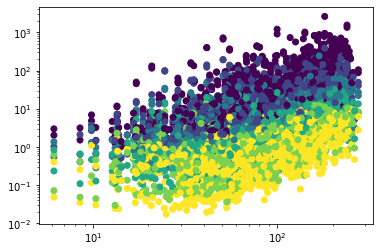

In [7]:
plt.scatter(df_full_rs["rho"], df_full_rs["sep_uncert"], c=np.log10(df_full_rs["total_energy"]))
plt.loglog()

In [12]:
dfs_full.index

MultiIndex([( 'Full optimistic triang', 200.0,           100000.0, 24),
            ( 'Full optimistic triang', 200.0,             1000.0, 16),
            ( 'Full optimistic triang', 110.0, 3162.2776601683795, 20),
            ( 'Full optimistic triang', 200.0,           100000.0, 16),
            ( 'Full optimistic triang', 200.0, 3162.2776601683795, 24),
            ( 'Full optimistic triang', 110.0,           100000.0, 20),
            ( 'Full optimistic triang', 170.0,            10000.0, 16),
            ( 'Full optimistic triang', 200.0,  316227.7660168379, 20),
            ( 'Full optimistic triang',  50.0,             1000.0, 16),
            ( 'Full optimistic triang',  50.0,           100000.0, 16),
            ...
            ('Full pessimistic triang',  80.0,             1000.0, 24),
            ('Full pessimistic triang', 200.0,            10000.0, 20),
            ('Full pessimistic triang', 110.0, 31622.776601683792, 16),
            ('Full pessimistic triang',  80.0,  

In [37]:
sel = dfs_full.loc["Full pessimistic cluster", 50, slice(None), 16].reset_index()
sel["energy"] = np.round(sel["energy"], decimals=4)

sel.groupby("energy").ngroups


6

In [18]:
dfs_full.pos_uncert.values

array([DeviceArray(0.15316456, dtype=float64),
       DeviceArray(2.1717247, dtype=float64),
       DeviceArray(0.15764432, dtype=float64), ...,
       DeviceArray(0.10792876, dtype=float64),
       DeviceArray(1.12350811, dtype=float64),
       DeviceArray(0.7271991, dtype=float64)], dtype=object)

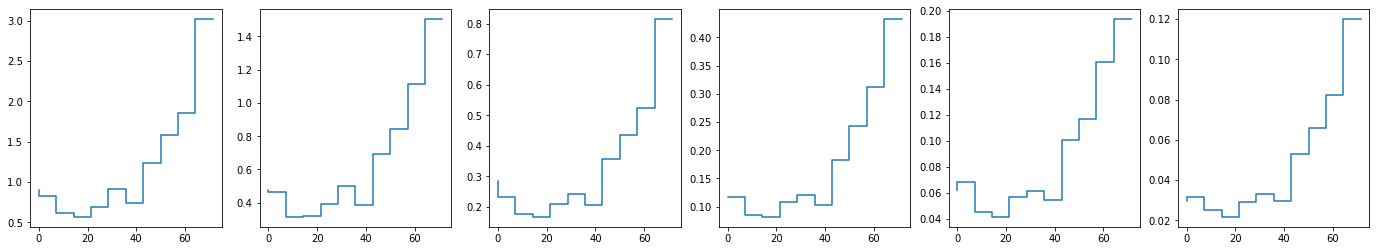

In [26]:
sel = dfs_full.loc["Full pessimistic cluster", 50, slice(None), 16].reset_index()
sel["energy"] = np.round(sel["energy"], decimals=4)


ne = len(np.unique(sel["energy"] ))

fig, axs = plt.subplots(1, ne, figsize=(ne*4, 4))

for ax, (energy, group) in zip(axs, sel.groupby("energy")):
    rhos = np.asarray(group["rho"].values)
    #dangle_dists = np.degrees(np.average(np.stack(group["dangle_dists"].values), axis=1))
    
    posuncert = np.asarray(group["pos_uncert"].values, dtype=np.float64)
    
    #sns.kdeplot(x=rhos, y=posuncert, ax=ax)
    bins = np.linspace(0, 100, 15)
    stat, _, _ = scipy.stats.binned_statistic(rhos, posuncert, bins=bins)
    ax.step(bins, np.append(stat, stat[-1]))




In [42]:
dfs_full.columns

Index(['position', 'theta', 'phi', 'fisher', 'pos', 'rho', 'contained',
       'dangle_dists', 'dangle_dists_mean', 'pos_uncert', 'x', 'y', 'z',
       'stheta', 'sphi', 't', 'logE', 'invfisch'],
      dtype='object')

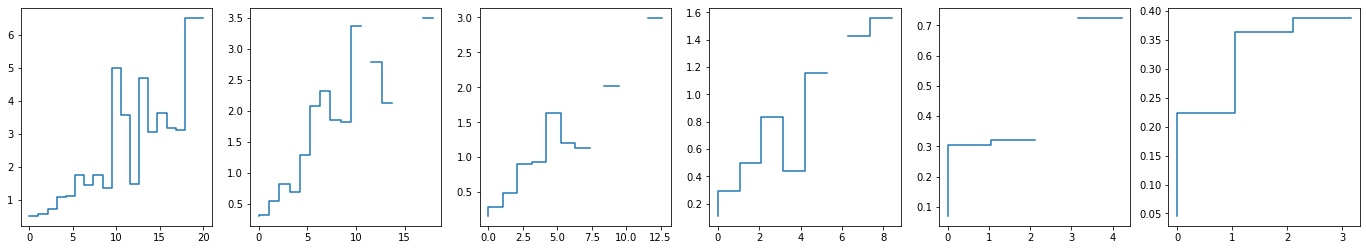

In [52]:
sel = dfs_full.loc["Full pessimistic cluster", 50, slice(None), 16].reset_index()
sel["energy"] = np.round(sel["energy"], decimals=4)


ne = len(np.unique(sel["energy"] ))

fig, axs = plt.subplots(1, ne, figsize=(ne*4, 4))

for ax, (energy, group) in zip(axs, sel.groupby("energy")):
    #costhetas = np.cos(np.asarray(group["theta"].values))
    #phis = np.asarray(group["phi"].values)
    dangle_dists = np.degrees(np.average(np.stack(group["dangle_dists"].values), axis=1))
    
    posuncert = np.asarray(group["pos_uncert"].values, dtype=np.float64)
    
    #sns.kdeplot(x=rhos, y=posuncert, ax=ax)
    bins = np.linspace(0, 20, 20)
    stat, _, _ = scipy.stats.binned_statistic(dangle_dists, posuncert, bins=bins)
    ax.step(bins, np.append(stat, stat[-1]))




In [73]:
uncerts = [1, 2, 5]
pos_res_acc = pd.concat([dfs_full.groupby(level=[0, 1, 2, 3])["pos_uncert"].agg(lambda s: np.sum(s < uncert) / len(s)) for uncert in uncerts],
    keys = uncerts,
    names= ["max_pos_uncert"]
)

pd.to_pickle(pos_res_acc, "data/em_casc_pos_uncert_accept_fisher.pickle")

In [65]:
pos_res_acc

max_pos_uncert  simmode                  spacing  energy         pmts
1               Full optimistic triang   50.0     1000.000000    16      0.870000
                                                                 20      0.915000
                                                                 24      0.935000
                                                  3162.277660    16      0.980000
                                                                 20      0.995000
                                                                           ...   
5               Full pessimistic triang  200.0    100000.000000  20      0.700508
                                                                 24      0.738693
                                                  316227.766017  16      0.833333
                                                                 20      0.871795
                                                                 24      0.883249
Name: pos_uncert, Length: 19

In [69]:
mpu_group.index.levels

FrozenList([[1, 2, 5], ['Full optimistic triang', 'MPE optimistic triang', 'MPE pessimistic cluster', 'MPE pessimistic triang', 'Full pessimistic cluster', 'Full pessimistic triang'], [50.0, 80.0, 110.0, 140.0, 170.0, 200.0], [1000.0, 3162.2776601683795, 10000.0, 31622.776601683792, 100000.0, 316227.7660168379], [16, 20, 24]])

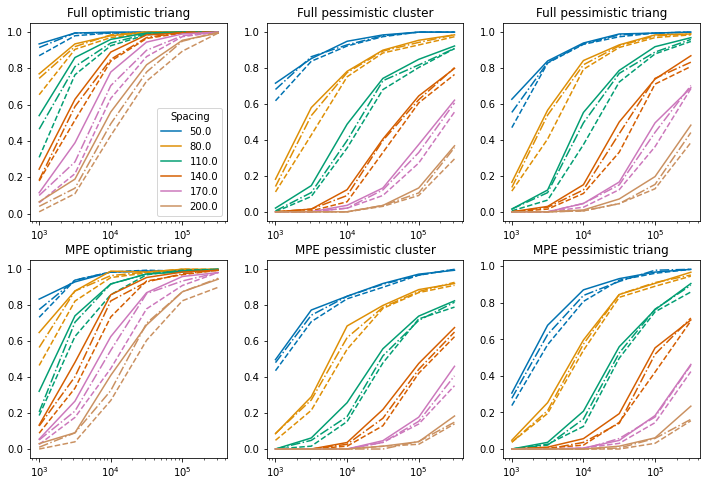

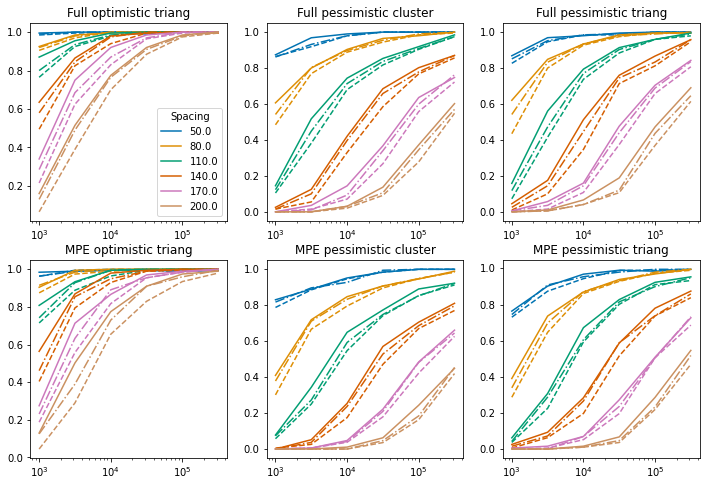

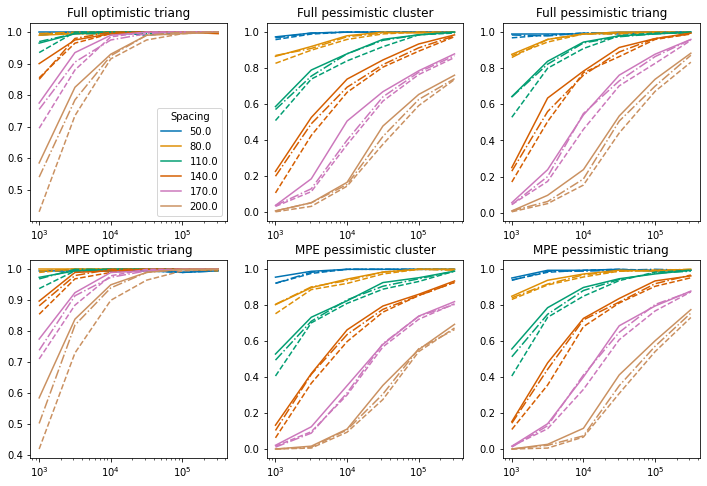

In [72]:

for (mpu, mpu_group) in pos_res_acc.groupby(level=0):
    fig, axs = plt.subplots(2, 3, figsize=(4*3, 4*2))
    colors = sns.color_palette("colorblind", len(mpu_group.index.levels[2]))
    lss = ["--", "-.", "-"]

    for ax, (sim_mode, sim_group) in zip(axs.ravel(), mpu_group.groupby(level=1)):
        for color, (spacing, spacing_group) in zip(colors, sim_group.groupby(level=2)):
            for ls, (pmts, pmt_group) in zip(lss, spacing_group.groupby(level=4)):
                ax.plot(pmt_group.index.levels[3], pmt_group.values, color=color, ls=ls)
        ax.set_xscale("log")
        ax.set_title(sim_mode)

    proxies = []
    labels = []
    for color, spacing in zip(colors, pos_res_acc.index.levels[2]):
        proxies.append(plt.Line2D([], [], color=color))
        labels.append(spacing)

    axs[0][0].legend(proxies, labels, title="Spacing")


In [15]:
def calc_tau_flux_uncert(rel_uncert, N_0):
    prob = scipy.stats.norm.cdf(rel_uncert)
    N = N_0 * prob
    flux_uncert = 1/np.sqrt(N)
    return flux_uncert


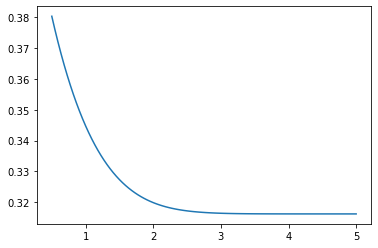

In [16]:
rel_uncert = np.linspace(0.5, 5, 100)
plt.plot(rel_uncert, [calc_tau_flux_uncert(uc, 10) for uc in rel_uncert])

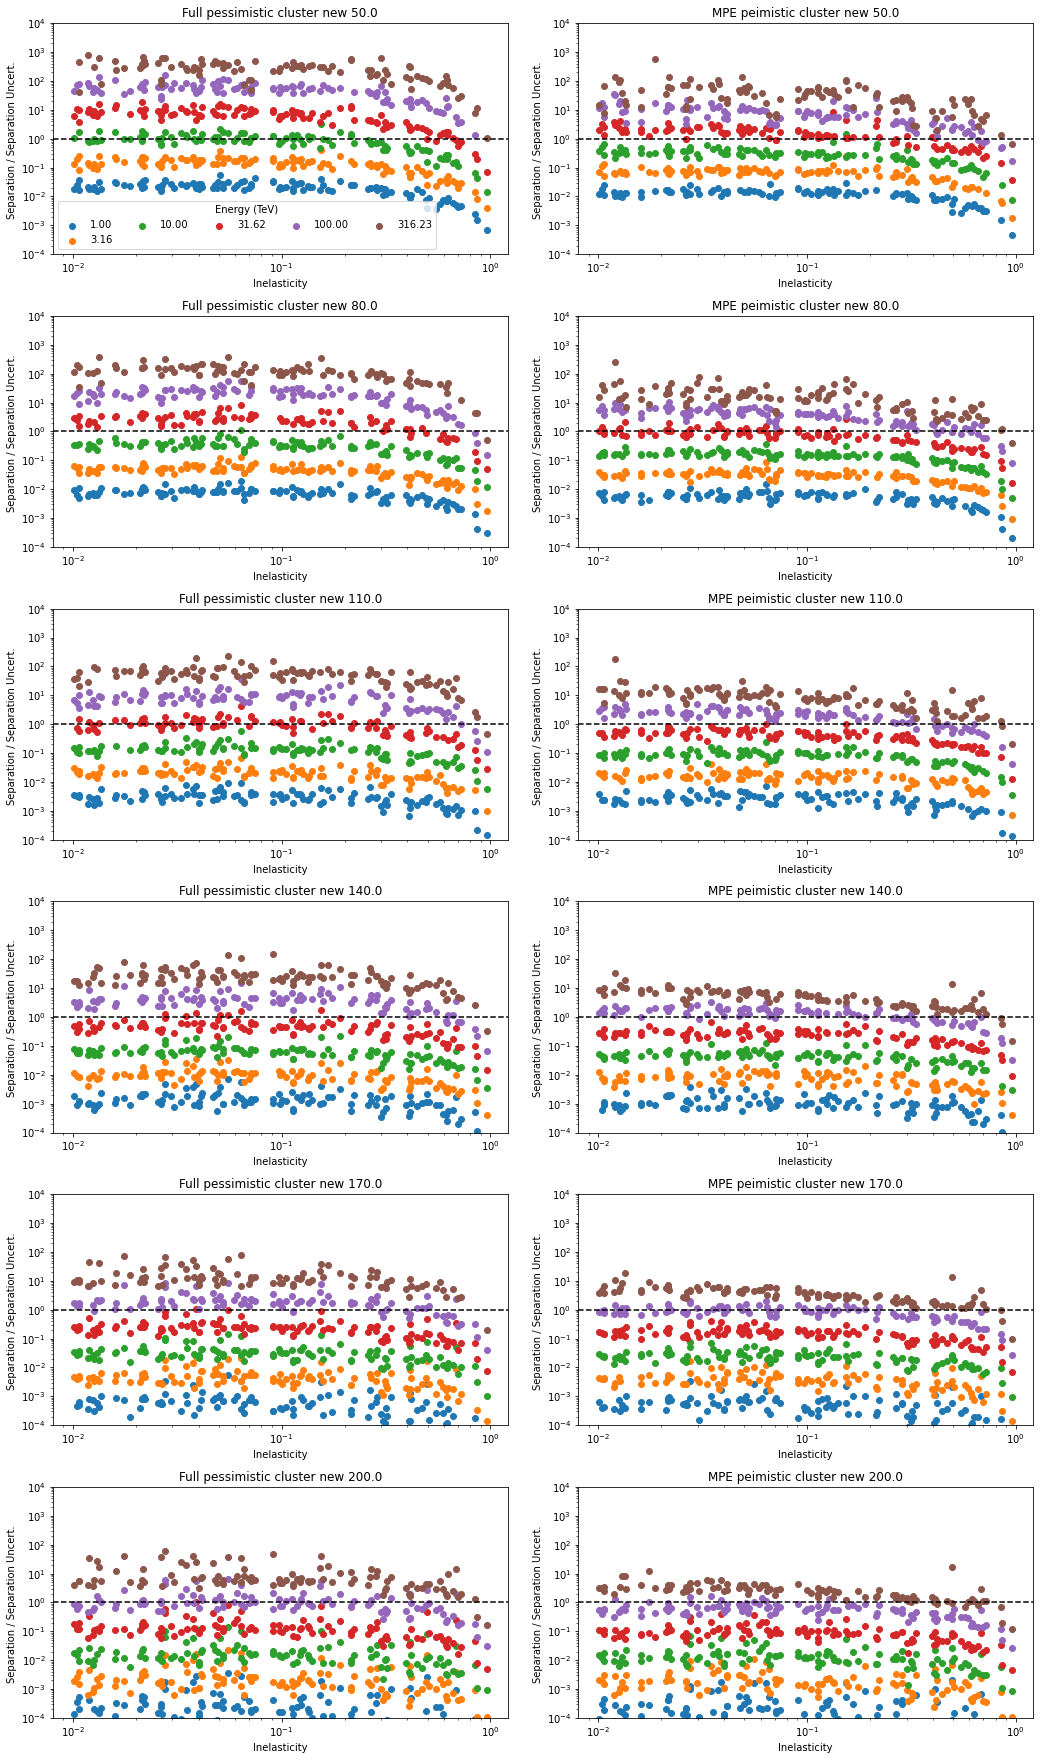

In [12]:

fig, axs = plt.subplots(6, 2, figsize=(16 / 2.2 * 2, 9/2.2 * 6))

for i, (groupn, group) in enumerate(df_full_rs.groupby("simmode")):
    for j, (groupn2, group2) in enumerate(group.groupby("spacing")):
        ax = axs[j][i]
        ax.set_title(f"{groupn} {groupn2}")
        for groupn3, group3 in group2.groupby(["total_energy"]):

           
            ax.scatter(group3.inelasticity, group3.separation /group3.sep_uncert ,  label=f"{groupn3 / 1000:.2f}")
            
           #ax.scatter(inelast, cr / sep,  label=f"{groupn2 / 1000:.2f}")

        ax.set_yscale("log")
        ax.set_xscale("log")

        ax.set_xlabel("Inelasticity")
        ax.set_ylabel("Separation / Separation Uncert. ")
        ax.axhline(1, ls="--", color="k")
        ax.set_ylim(1E-4, 1E4)
axs[0][0].legend(title="Energy (TeV)", ncol=5)
plt.tight_layout()
plt.savefig(f"figures/em_double_casc_sep_vs_inelas.png", dpi=150)

In [ ]:
baseline_sig_df = df_sel.loc[(slice(None), energies[-2], slice(16))]
baseline_sig = np.asarray([ps_sign(np.radians(np.radians(res)), sp, 0.001, 5E-7)
 for sp, res in zip(baseline_sig_df.index.get_level_values(0), baseline_sig_df.ang_res_sampl)])

axs[1].plot(baseline_sig_df.index.get_level_values(0), baseline_sig/baseline_sig[0], ls="-")
axs[1].set_ylabel("Relative PS Significance")
axs[1].set_xlabel("Spacing (m)")

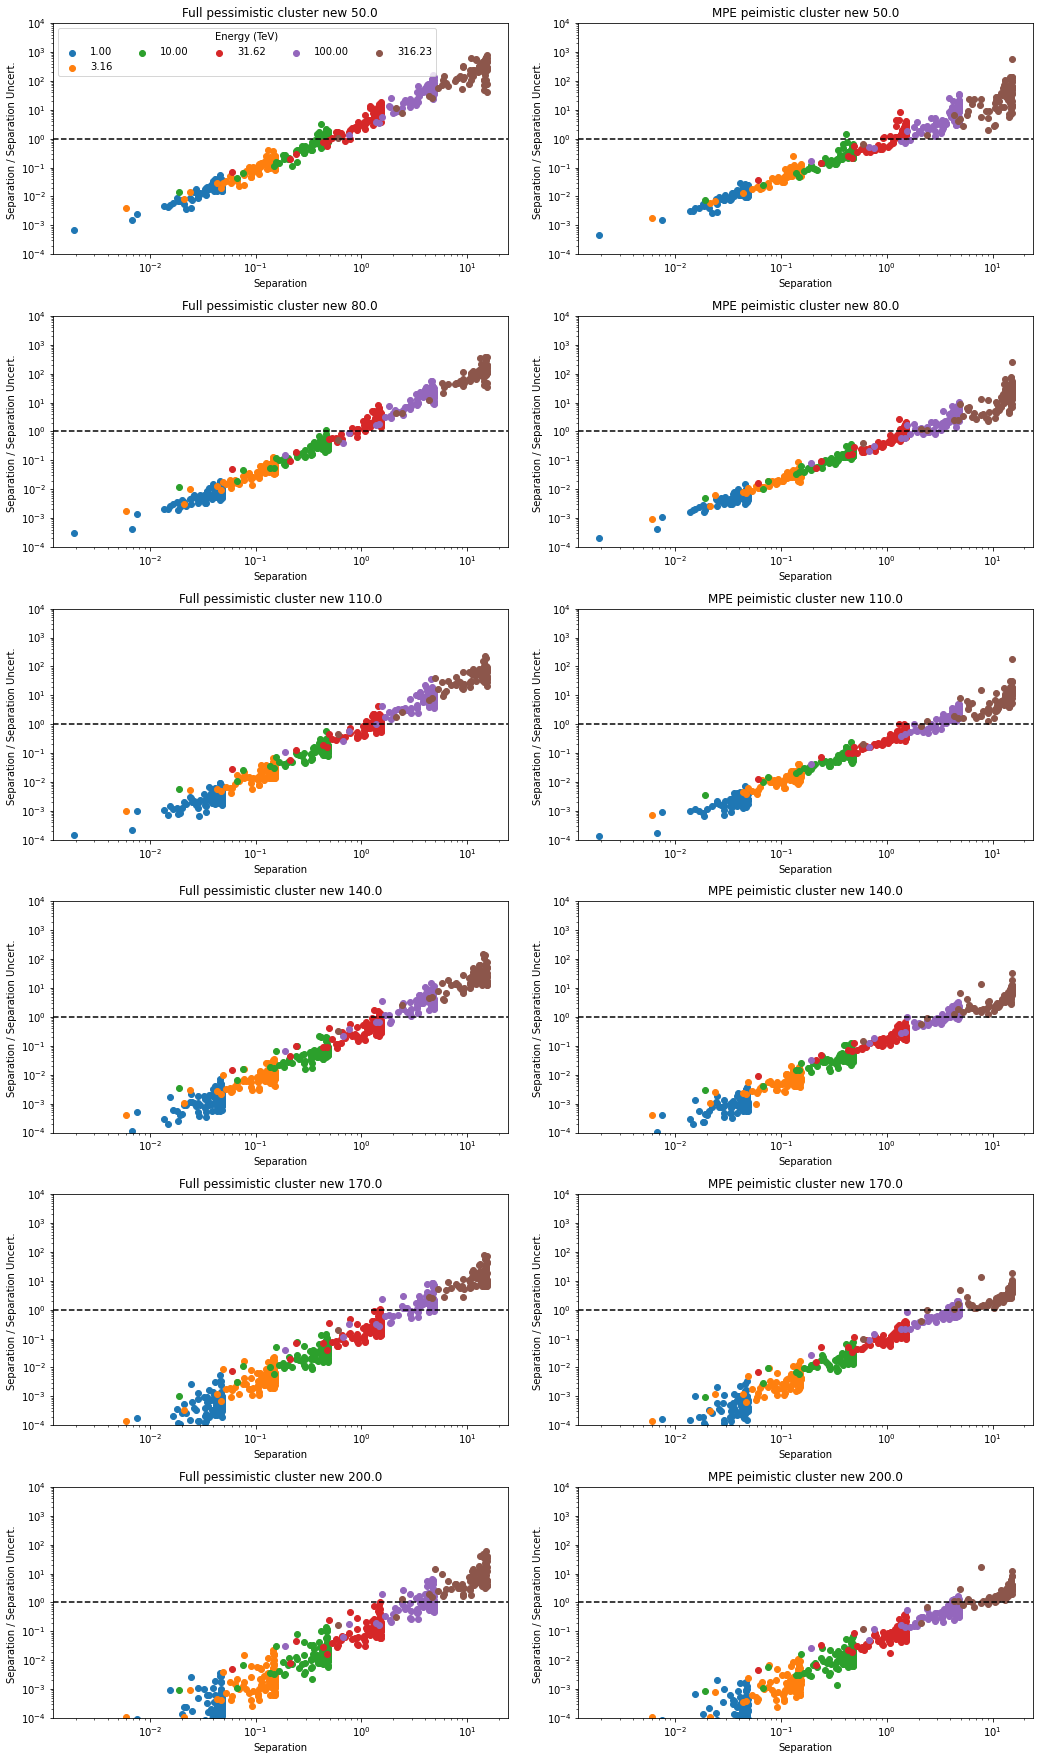

In [13]:
fig, axs = plt.subplots(6, 2, figsize=(16 / 2.2 * 2, 9/2.2 * 6))

for i, (groupn, group) in enumerate(df_full_rs.groupby("simmode")):
    for j, (groupn2, group2) in enumerate(group.groupby("spacing")):
        ax = axs[j][i]
        ax.set_title(f"{groupn} {groupn2}")
        for groupn3, group3 in group2.groupby(["total_energy"]):
            ax.scatter(group3.separation, group3.separation /group3.sep_uncert ,  label=f"{groupn3 / 1000:.2f}")
            
           #ax.scatter(inelast, cr / sep,  label=f"{groupn2 / 1000:.2f}")

        ax.set_yscale("log")
        ax.set_xscale("log")

        ax.set_xlabel("Separation")
        ax.set_ylabel("Separation / Separation Uncert. ")
        ax.axhline(1, ls="--", color="k")
        ax.set_ylim(1E-4, 1E4)
axs[0][0].legend(title="Energy (TeV)", ncol=5)
plt.tight_layout()
plt.savefig(f"figures/em_double_casc_sep_vs_sep.png", dpi=150)

In [15]:
def calc_vol(spacing, cluster=True):
   
    if cluster:
        det = Detector(make_hex_grid(3, spacing, 1, 1, truncate=1))
    else:
        det = make_triang(spacing, 1, 1)
    chull_points = sg.convex_hull.graham_andrew([sg.Point2(*c) for c in det.module_coords[:, [0, 1]]])
    chull_poly = sg.Polygon(chull_points)
    return float(chull_poly.area()) * 1000

def ps_sign(ang_res, spacing, sosb, ns):
    vol = calc_vol(spacing, True)
    sig = sosb * ns * vol
    bg = ns * (1 - sosb) * vol * ang_res **2
    sign = sig / np.sqrt(bg)

    return sign

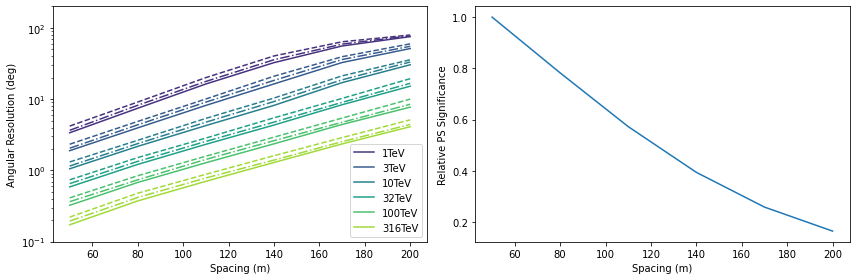

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(2*6, 1*4))
#dfssel = dfs.loc[(slice(None), slice(None), slice(None), 16)]

energies =  np.unique(dfs.index.get_level_values(2))
colormap = sns.color_palette("viridis", len(energies))

linestyles = ["--", "-.", "-"]


df_sel = dfs.loc[("Full pessimistic cluster", slice(None),  slice(None), slice(None))]
#df_sel_cont = df_sel.loc[df_sel.contained]

#ps_sign(np.radians(0.1), x, 0.001, 5E-7) for x in xs

baseline_sig_df = df_sel.loc[(slice(None), energies[-2], slice(16))]
baseline_sig = np.asarray([ps_sign(np.radians(np.radians(res)), sp, 0.001, 5E-7)
 for sp, res in zip(baseline_sig_df.index.get_level_values(0), baseline_sig_df.ang_res_sampl)])

axs[1].plot(baseline_sig_df.index.get_level_values(0), baseline_sig/baseline_sig[0], ls="-")
axs[1].set_ylabel("Relative PS Significance")
axs[1].set_xlabel("Spacing (m)")


for i, (energy, group) in enumerate(df_sel.groupby(level=1)):
    for ls, (pmts, group3) in zip(linestyles, group.groupby(level=2)):
        spacings = group3.index.get_level_values(0)
        ang_res = group3.ang_res_sampl
        axs[0].plot(spacings, ang_res, color=colormap[i], ls=ls)

        
        #sign = np.asarray([ps_sign(np.radians(np.radians(res)), sp, 0.001, 5E-7) for sp, res in zip(spacings, ang_res)])
        

        

axs[0].set_yscale("log")
axs[0].set_xlabel("Spacing (m)")
axs[0].set_ylim(0.1, 200)
axs[0].set_ylabel("Angular Resolution (deg)")

proxies = [plt.Line2D([], [], color=colormap[i]) for i in range(len(energies))]
labels = [f"{e/1000:.0f}TeV" for e in energies]


axs[0].legend(proxies, labels, loc="lower right")
plt.tight_layout()
plt.savefig(f"figures/em_casc_edep_res_comp_ps_sign.png", dpi=150)

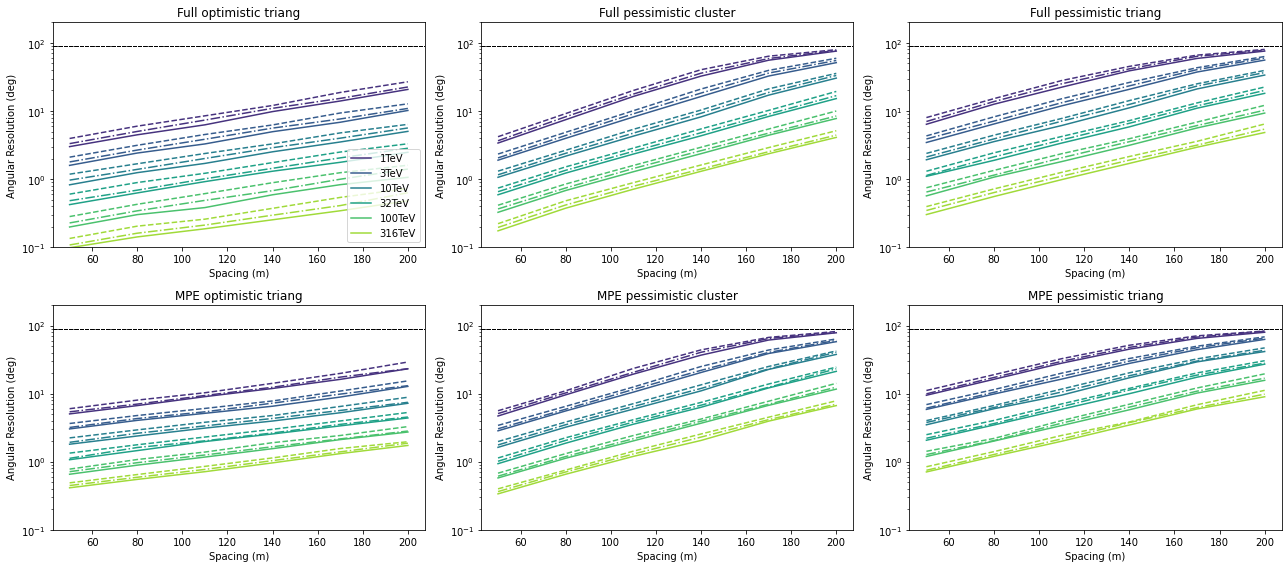

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(3*6, 2*4))

#dfssel = dfs.loc[(slice(None), slice(None), slice(None), 16)]

energies =  np.unique(dfs.index.get_level_values(2))
colormap = sns.color_palette("viridis", len(energies))

linestyles = ["--", "-.", "-"]


for i, (energy, group) in enumerate(dfs.groupby(level=2)):   
    for ax, (mode, group2) in zip(axs.ravel(), group.groupby(level=0)):
        for ls, (pmts, group3) in zip(linestyles, group2.groupby(level=3)):
            ax.plot(group3.index.get_level_values(1), group3.ang_res_sampl, color=colormap[i], ls=ls)
        ax.set_yscale("log")
        ax.set_xlabel("Spacing (m)")
        ax.set_ylim(0.1, 200)
        ax.set_title(mode)
        ax.set_ylabel("Angular Resolution (deg)")
        ax.axhline(90, ls="--", color="k", lw=1)

proxies = [plt.Line2D([], [], color=colormap[i]) for i in range(len(energies))]
labels = [f"{e/1000:.0f}TeV" for e in energies]


axs[0][0].legend(proxies, labels, loc="lower right")
plt.tight_layout()
plt.savefig(f"figures/em_casc_edep_res_comp.png", dpi=150)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(3*6, 2*4))

#dfssel = dfs.loc[(slice(None), slice(None), slice(None), 16)]
energies =  np.unique(dfs.index.get_level_values(2))
spacings =  np.unique(dfs.index.get_level_values(1))
colormap = sns.color_palette("viridis", len(energies))

linestyles = ["--", "-.", "-"]


for i, (spacing, group) in enumerate(dfs.groupby(level=1)):   
    for ax, (mode, group2) in zip(axs.ravel(), group.groupby(level=0)):
        for ls, (pmts, group3) in zip(linestyles, group2.groupby(level=3)):
            es = group3.index.get_level_values(2)
            ax.plot(es, group3.logE * np.log(10), color=colormap[i], ls=ls)
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlabel("Energy (GeV)")
        ax.set_ylim(0.01, 10)
        ax.set_title(mode)
        ax.set_ylabel(r"Relative Energy Resolution ($\sigma E / E$")

proxies = [plt.Line2D([], [], color=colormap[i]) for i in range(len(energies))]
labels = [f"{s:.0f}m" for s in spacings]


axs[0][0].legend(proxies, labels, loc="lower right")
plt.tight_layout()
plt.savefig(f"figures/em_casc_sdep_eres_comp.png", dpi=150)

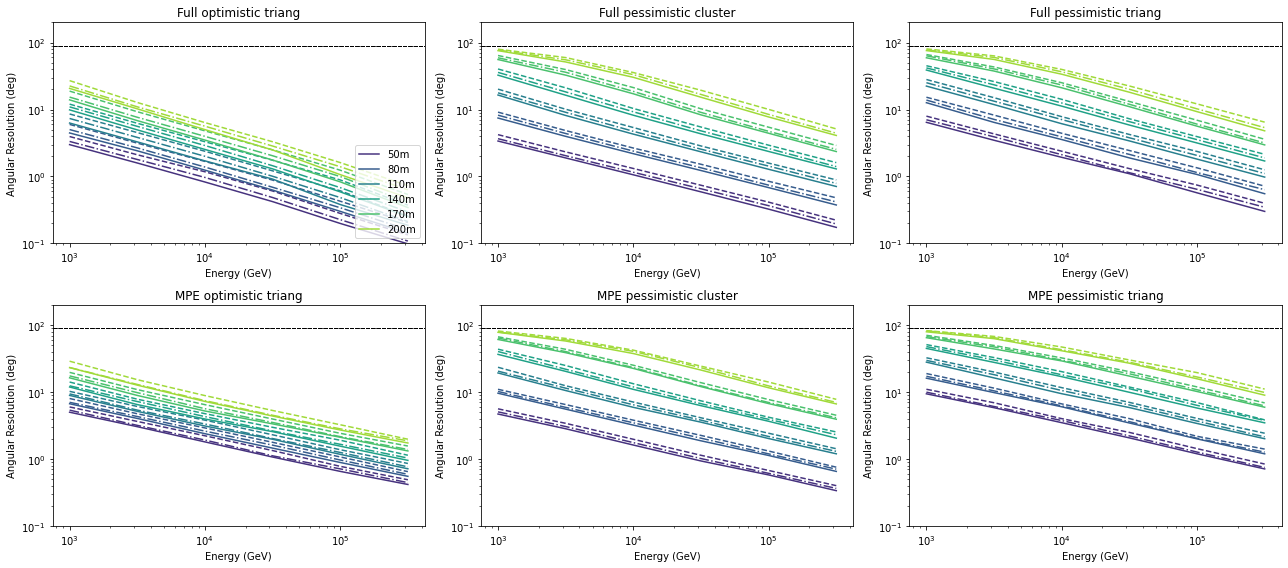

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(3*6, 2*4))

#dfssel = dfs.loc[(slice(None), slice(None), slice(None), 16)]
energies =  np.unique(dfs.index.get_level_values(2))
spacings =  np.unique(dfs.index.get_level_values(1))
colormap = sns.color_palette("viridis", len(energies))

linestyles = ["--", "-.", "-"]


for i, (spacing, group) in enumerate(dfs.groupby(level=1)):   
    for ax, (mode, group2) in zip(axs.ravel(), group.groupby(level=0)):
        for ls, (pmts, group3) in zip(linestyles, group2.groupby(level=3)):
            es = group3.index.get_level_values(2)
            ax.plot(es, group3.ang_res_sampl, color=colormap[i], ls=ls)
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlabel("Energy (GeV)")
        ax.set_ylim(0.1, 200)
        ax.set_title(mode)
        ax.set_ylabel("Angular Resolution (deg)")
        ax.axhline(90, ls="--", color="k", lw=1)

proxies = [plt.Line2D([], [], color=colormap[i]) for i in range(len(energies))]
labels = [f"{s:.0f}m" for s in spacings]


axs[0][0].legend(proxies, labels, loc="lower right")
plt.tight_layout()
plt.savefig(f"figures/em_casc_edep_res_comp.png", dpi=150)

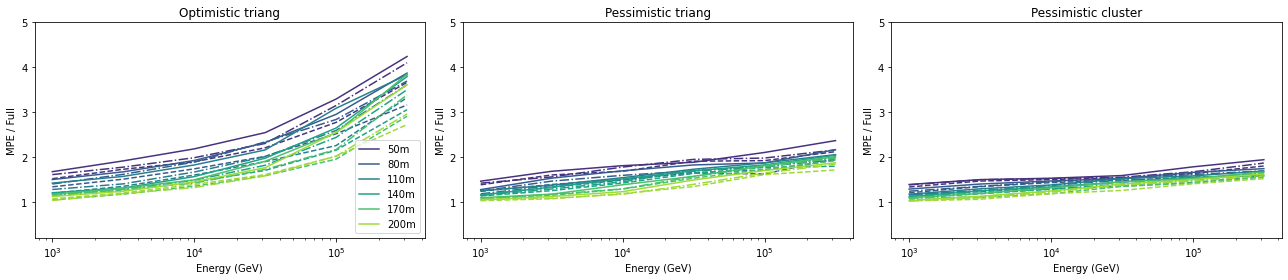

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(3*6, 1*4))

#dfssel = dfs.loc[(slice(None), slice(None), slice(None), 16)]

energies =  np.unique(dfs.index.get_level_values(2))
colormap = sns.color_palette("viridis", len(energies))

linestyles = ["--", "-.", "-"]

mode_ratios = [
    ("Full optimistic triang", "MPE optimistic triang", "Optimistic triang"),
    ('Full pessimistic triang', 'MPE pessimistic triang', "Pessimistic triang"),
    ('Full pessimistic cluster', 'MPE pessimistic cluster', "Pessimistic cluster")
]

#dfssel = dfs.loc[(slice(None), slice(None), slice(None), 16)]
energies =  np.unique(dfs.index.get_level_values(2))
spacings =  np.unique(dfs.index.get_level_values(1))
colormap = sns.color_palette("viridis", len(energies))

linestyles = ["--", "-.", "-"]


for i, (spacing, group) in enumerate(dfs.groupby(level=1)):   
    for ls, (pmts, group2) in zip(linestyles, group.groupby(level=3)):
        for ax, mr  in zip(axs.ravel(), mode_ratios):        
            ratio = group2.loc[(mr[1], slice(None))].ang_res_sampl / group2.loc[(mr[0], slice(None))].ang_res_sampl
            es = ratio.index.get_level_values(1)   
            ax.plot(es, ratio, color=colormap[i], ls=ls)
            #ax.set_yscale("log")
            ax.set_xscale("log")
            ax.set_xlabel("Energy (GeV)")
            ax.set_ylim(0.2, 5)
            ax.set_title(mr[2])
            ax.set_ylabel(r"MPE / Full")

proxies = [plt.Line2D([], [], color=colormap[i]) for i in range(len(energies))]
labels = [f"{s:.0f}m" for s in spacings]


axs[0].legend(proxies, labels, loc="lower right")
plt.tight_layout()


plt.savefig(f"figures/em_casc_edep_ang_res_ratio.png", dpi=150)

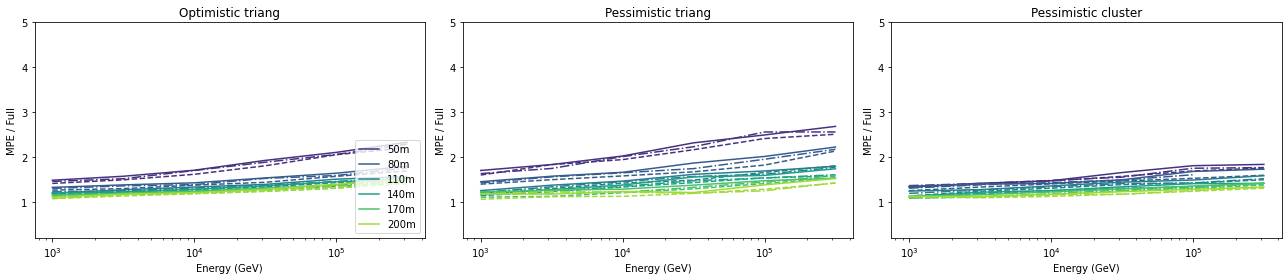

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(3*6, 1*4))

#dfssel = dfs.loc[(slice(None), slice(None), slice(None), 16)]

energies =  np.unique(dfs.index.get_level_values(2))
colormap = sns.color_palette("viridis", len(energies))

linestyles = ["--", "-.", "-"]

mode_ratios = [
    ("Full optimistic triang", "MPE optimistic triang", "Optimistic triang"),
    ('Full pessimistic triang', 'MPE pessimistic triang', "Pessimistic triang"),
    ('Full pessimistic cluster', 'MPE pessimistic cluster', "Pessimistic cluster")
]

#dfssel = dfs.loc[(slice(None), slice(None), slice(None), 16)]
energies =  np.unique(dfs.index.get_level_values(2))
spacings =  np.unique(dfs.index.get_level_values(1))
colormap = sns.color_palette("viridis", len(energies))

linestyles = ["--", "-.", "-"]


for i, (spacing, group) in enumerate(dfs.groupby(level=1)):   
    for ls, (pmts, group2) in zip(linestyles, group.groupby(level=3)):
        for ax, mr  in zip(axs.ravel(), mode_ratios):        
            ratio = group2.loc[(mr[1], slice(None))].logE / group2.loc[(mr[0], slice(None))].logE
            es = ratio.index.get_level_values(1)   
            ax.plot(es, ratio, color=colormap[i], ls=ls)
            #ax.set_yscale("log")
            ax.set_xscale("log")
            ax.set_xlabel("Energy (GeV)")
            ax.set_ylim(0.2, 5)
            ax.set_title(mr[2])
            ax.set_ylabel(r"MPE / Full")

proxies = [plt.Line2D([], [], color=colormap[i]) for i in range(len(energies))]
labels = [f"{s:.0f}m" for s in spacings]


axs[0].legend(proxies, labels, loc="lower right")
plt.tight_layout()


plt.savefig(f"figures/em_casc_edep_energy_res_ratio.png", dpi=150)

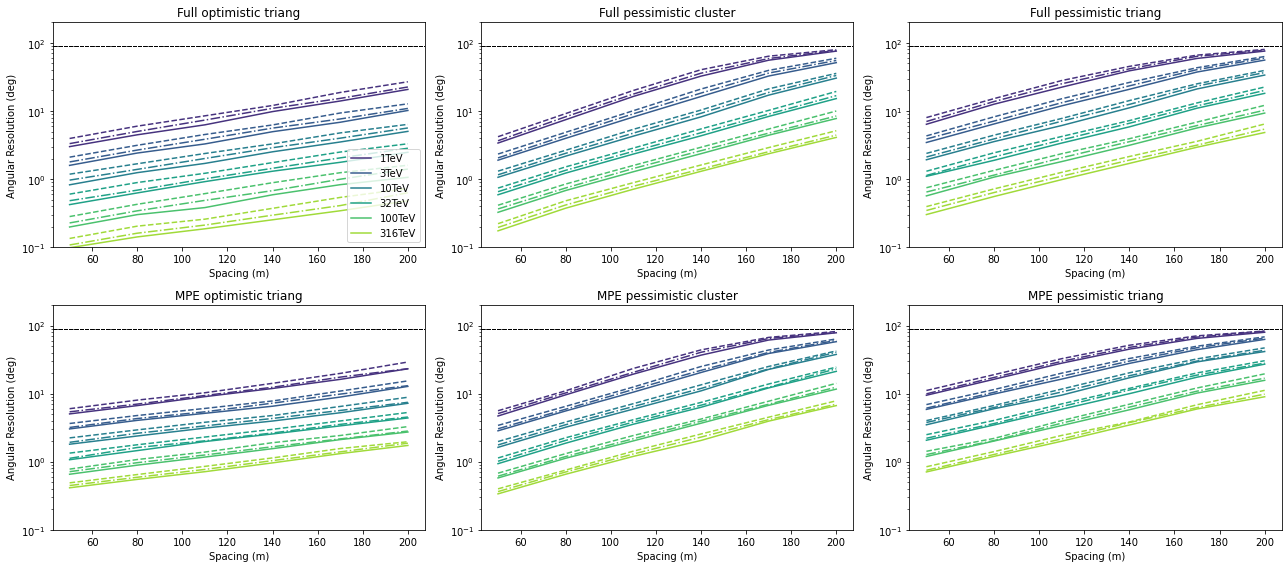

In [11]:

fig, axs = plt.subplots(2, 3, figsize=(3*6, 2*4))

#dfssel = dfs.loc[(slice(None), slice(None), slice(None), 16)]

energies =  np.unique(dfs.index.get_level_values(2))
colormap = sns.color_palette("viridis", len(energies))

linestyles = ["--", "-.", "-"]


for i, (energy, group) in enumerate(dfs.groupby(level=2)):   
    for ax, (mode, group2) in zip(axs.ravel(), group.groupby(level=0)):
        for ls, (pmts, group3) in zip(linestyles, group2.groupby(level=3)):
            ax.plot(group3.index.get_level_values(1), group3.ang_res_sampl, color=colormap[i], ls=ls)
        ax.set_yscale("log")
        ax.set_xlabel("Spacing (m)")
        ax.set_ylim(0.1, 200)
        ax.set_title(mode)
        ax.set_ylabel("Angular Resolution (deg)")
        ax.axhline(90, ls="--", color="k", lw=1)

proxies = [plt.Line2D([], [], color=colormap[i]) for i in range(len(energies))]
labels = [f"{e/1000:.0f}TeV" for e in energies]


axs[0][0].legend(proxies, labels, loc="lower right")
plt.tight_layout()
plt.savefig(f"figures/em_casc_sdep_res_comp.png", dpi=150)

In [9]:
dfs.columns

Index(['x', 'y', 'z', 'stheta', 'sphi', 't', 'logE', 'ang_res_sampl',
       'theta_deg', 'phi_deg', 'ang_res_circ'],
      dtype='object')

In [ ]:
y = 10^x
dy / dx = log(10) * y
sy / y = sx * dy / dx

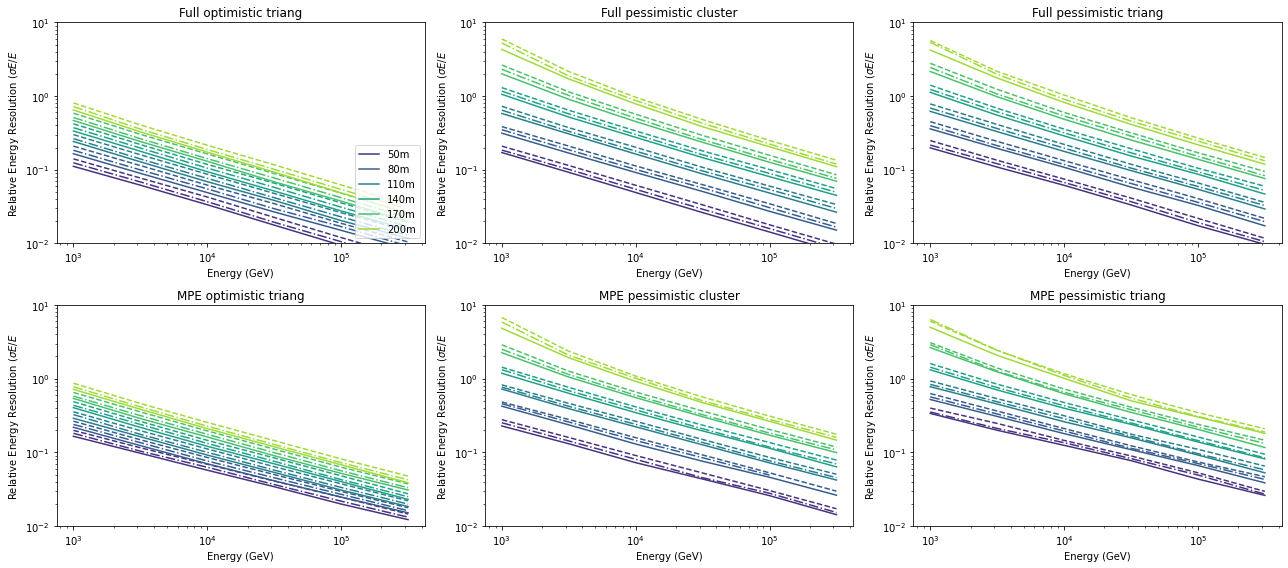

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(3*6, 2*4))

#dfssel = dfs.loc[(slice(None), slice(None), slice(None), 16)]
energies =  np.unique(dfs.index.get_level_values(2))
spacings =  np.unique(dfs.index.get_level_values(1))
colormap = sns.color_palette("viridis", len(energies))

linestyles = ["--", "-.", "-"]


for i, (spacing, group) in enumerate(dfs.groupby(level=1)):   
    for ax, (mode, group2) in zip(axs.ravel(), group.groupby(level=0)):
        for ls, (pmts, group3) in zip(linestyles, group2.groupby(level=3)):
            es = group3.index.get_level_values(2)
            ax.plot(es, group3.logE * np.log(10), color=colormap[i], ls=ls)
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlabel("Energy (GeV)")
        ax.set_ylim(0.01, 10)
        ax.set_title(mode)
        ax.set_ylabel(r"Relative Energy Resolution ($\sigma E / E$")

proxies = [plt.Line2D([], [], color=colormap[i]) for i in range(len(energies))]
labels = [f"{s:.0f}m" for s in spacings]


axs[0][0].legend(proxies, labels, loc="lower right")
plt.tight_layout()
plt.savefig(f"figures/em_casc_sdep_eres_comp.png", dpi=150)

In [42]:
dfs.columns

Index(['x', 'y', 'z', 'stheta', 'sphi', 't', 'logE', 'ang_res_sampl',
       'theta_deg', 'phi_deg', 'ang_res_circ'],
      dtype='object')

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(3*6, 2*4))

#dfssel = dfs.loc[(slice(None), slice(None), slice(None), 16)]
energies =  np.unique(dfs.index.get_level_values(2))
spacings =  np.unique(dfs.index.get_level_values(1))
colormap = sns.color_palette("viridis", len(energies))

linestyles = ["--", "-.", "-"]


for i, (spacing, group) in enumerate(dfs.groupby(level=1)):   
    for ax, (mode, group2) in zip(axs.ravel(), group.groupby(level=0)):
        for ls, (pmts, group3) in zip(linestyles, group2.groupby(level=3)):
            ax.plot(group3.index.get_level_values(2), group3.ang_res_sampl, color=colormap[i], ls=ls)
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlabel("Energy (GeV)")
        ax.set_ylim(0.1, 200)
        ax.set_title(mode)
        ax.set_ylabel("Angular Resolution (deg)")

proxies = [plt.Line2D([], [], color=colormap[i]) for i in range(len(energies))]
labels = [f"{s:.0f}m" for s in spacings]


axs[0][0].legend(proxies, labels, loc="lower right")
plt.tight_layout()
plt.savefig(f"figures/em_casc_sdep_res_comp.png", dpi=150)

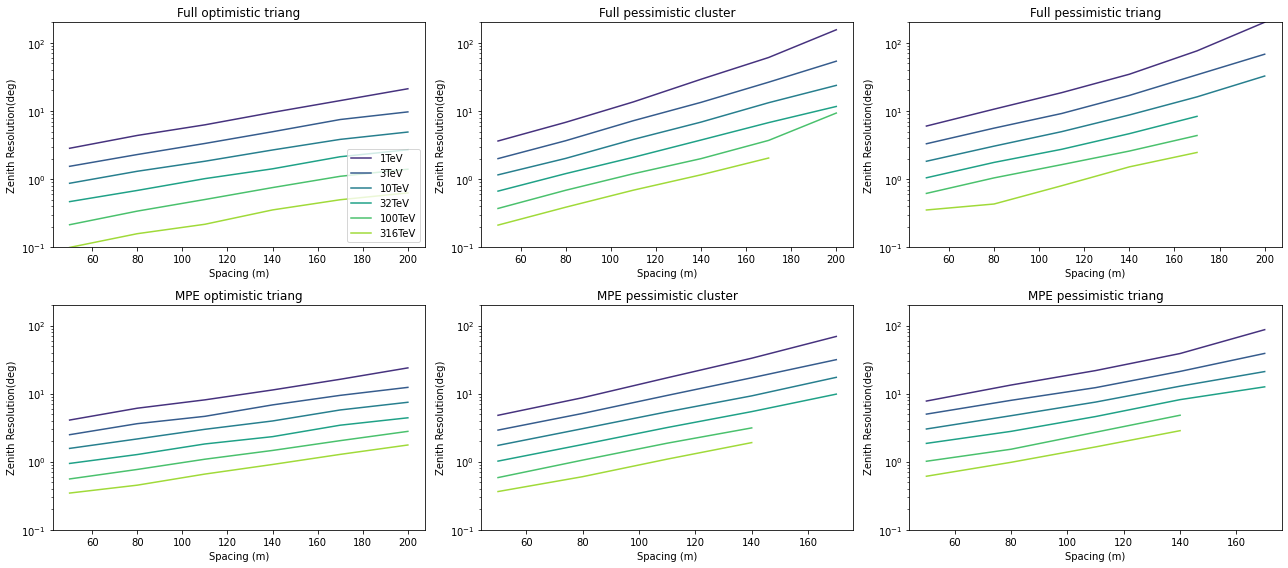

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(3*6, 2*4))

dfssel = dfs.loc[(slice(None), slice(None), slice(None), 16)]

energies =  np.unique(dfs.index.get_level_values(2))
colormap = sns.color_palette("viridis", len(energies))

linestyles = ["--", "-.", "-"]


for i, (energy, group) in enumerate(dfssel.groupby(level=2)):   
    for ax, (mode, group2) in zip(axs.ravel(), group.groupby(level=0)): 
        ax.plot(group2.index.get_level_values(1), group2.theta_deg, color=colormap[i])
        ax.set_yscale("log")
        ax.set_xlabel("Spacing (m)")
        ax.set_ylim(0.1, 200)
        ax.set_title(mode)
        ax.set_ylabel("Zenith Resolution(deg)")

proxies = [plt.Line2D([], [], color=colormap[i]) for i in range(len(energies))]
labels = [f"{e/1000:.0f}TeV" for e in energies]


axs[0][0].legend(proxies, labels, loc="lower right")
plt.tight_layout()
plt.savefig(f"figures/em_casc_edep_res_comp.png", dpi=150)

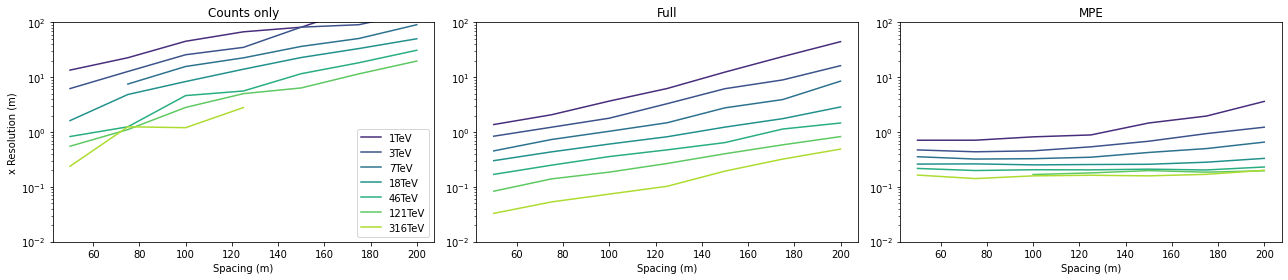

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(3*6, 4))

dfssel = dfs.loc[(slice(None), slice(None), slice(None), 16)]

energies =  np.unique(dfs.index.get_level_values(2))
colormap = sns.color_palette("viridis", len(energies))

linestyles = ["--", "-.", "-"]


for i, (energy, group) in enumerate(dfssel.groupby(level=2)):   
    for ax, (mode, group2) in zip(axs, group.groupby(level=0)): 
        ax.plot(group2.index.get_level_values(1), group2.x, color=colormap[i])
        ax.set_yscale("log")
        ax.set_xlabel("Spacing (m)")
        ax.set_ylim(0.01, 100)
        ax.set_title(mode)
axs[0].set_ylabel("x Resolution (m)")

proxies = [plt.Line2D([], [], color=colormap[i]) for i in range(len(energies))]
labels = [f"{e/1000:.0f}TeV" for e in energies]


axs[0].legend(proxies, labels, loc="lower right")
plt.tight_layout()
#plt.savefig(f"figures/em_casc_edep_res_comp.png", dpi=150)

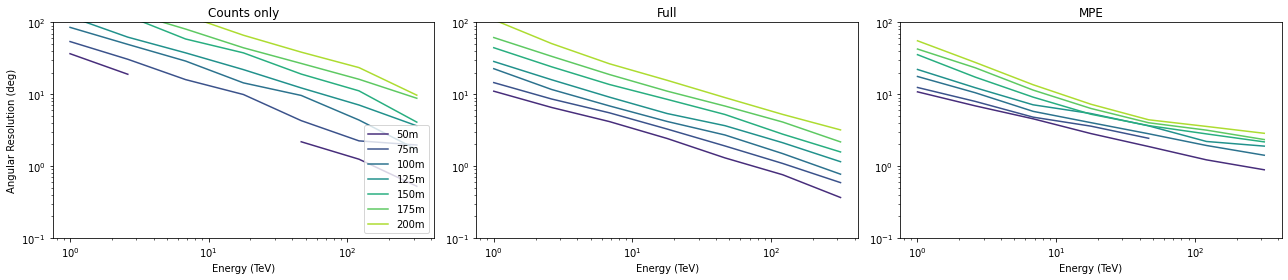

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(3*6, 4))

dfssel = dfs.loc[(slice(None), slice(None), slice(None), 16)]

spacings =  np.unique(dfs.index.get_level_values(1))
colormap = sns.color_palette("viridis", len(spacings))

linestyles = ["--", "-.", "-"]


for i, (spacing, group) in enumerate(dfssel.groupby(level=1)):   
    for ax, (mode, group2) in zip(axs, group.groupby(level=0)): 
        ax.plot(group2.index.get_level_values(2) / 1E3, group2.ang_res, color=colormap[i])
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Energy (TeV)")
        ax.set_ylim(0.1, 100)
        ax.set_title(mode)
axs[0].set_ylabel("Angular Resolution (deg)")

proxies = [plt.Line2D([], [], color=colormap[i]) for i in range(len(energies))]
labels = [f"{s:.0f}m" for s in spacings]


axs[0].legend(proxies, labels, loc="lower right")
plt.tight_layout()
#plt.savefig(f"figures/em_casc_edep_res_comp.png", dpi=150)

In [11]:
pickle.load(open("test_full_100.pickle", "rb"))[0]["fisher"]

FileNotFoundError: [Errno 2] No such file or directory: 'test_full_100.pickle'

In [7]:
#np.diag(np.linalg.inv(pickle.load(open("test_double_full_cluster.pickle", "rb"))[0]["fisher"]))

df, df_full = read_data("test_double_full_cluster.pickle", varnames_double_casc)

In [8]:
df_full = df_full.reset_index()
df_full["total_energy"] = df_full["energy"] + df_full["energy2"]
df_full["inelasticity"] = df_full["energy"] / df_full["total_energy"] 


In [11]:
df_full

,spacing,energy,pmts,time,theta,phi,pos,energy2,separation,particle_id,...,z,stheta,sphi,t,logE,logE2,logseparation,invfisch,total_energy,inelasticity
0,100.0,681.505346,16,0.0,2.266327,0.155061,"[115.85352336392874, -47.388707753128855, -122...",49318.494654,2.415596,11,...,2.207300,0.044109,0.066157,7.143588,6.392599,0.121600,3.639718,"[4.1546974, 3.3774846, 2.2072997, 0.044109475,...",50000.0,0.013630
1,100.0,1357.575442,16,0.0,0.654516,0.060702,"[-91.25488837953311, -43.367318908943105, 36.5...",48642.424558,2.382483,11,...,1.231543,0.032669,0.037401,4.216203,2.194729,0.063132,0.935980,"[1.3654913, 1.5695119, 1.2315433, 0.032669455,...",50000.0,0.027152
2,100.0,2923.464286,16,0.0,1.027737,2.010727,"[-65.7754538119476, -39.9792840408409, -479.34...",47076.535714,2.305786,11,...,0.627882,0.020992,0.017563,4.154206,1.298201,0.102168,0.569998,"[0.55795825, 0.7293738, 0.62788224, 0.02099159...",50000.0,0.058469


0.7855809080781904 2.4155962132994313
0.49991422162394855 2.3824826242916832
0.7930775824787529 2.3057861397749226


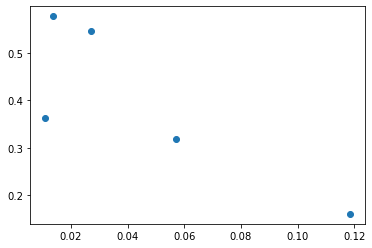

In [21]:
plt.plot(df_full["inelasticity"], df_full["logseparation"] * df_full["separation"] * np.log(10), "o")

In [21]:

dfile = pickle.load(open("", "rb"))

cov = np.linalg.inv(dfile["fisher"])
#sns.heatmap(cov)
print(np.diag(cov)[-1] * dfile["separation"] * np.log(10))

"""
dfile = pickle.load(open("test_double_tfirst_cluster.pickle", "rb"))

cov = np.linalg.inv(dfile["fisher"])
#sns.heatmap(cov)
print(np.diag(cov)[-1] * dfile["separation"] * np.log(10))
"""

0.4838533707161063
1.107629770961741


In [13]:
np.std(10**np.random.normal(1, 0.01, size=1000))

0.22885561573500604

In [14]:
np.log(10) * 10**(1) * 0.01

0.2302585092994046

In [ ]:
np.degrees(np.sqrt(np.diag(np.linalg.inv(pickle.load(open("test_full_100_1.pickle", "rb"))["fisher"])))[3:5])

array([3.1462488, 1.9691067], dtype=float32)

In [ ]:
np.sqrt(np.diag(np.linalg.inv(pickle.load(open("test_tfirst.pickle", "rb"))["fisher"])))

array([0.65879464, 0.39487773, 0.51115453, 0.20087601, 0.13765867,
       0.7746064 , 0.16937163], dtype=float32)

In [ ]:
label_map = {
    "x": "x (m)",
    "y": "y (m)",
    "z": "z (m)", 
    "t": "t (ns)",
    "ang_res": "$\Delta\Psi$ (deg)",
    "logE": "log10(E/GeV)"
    }


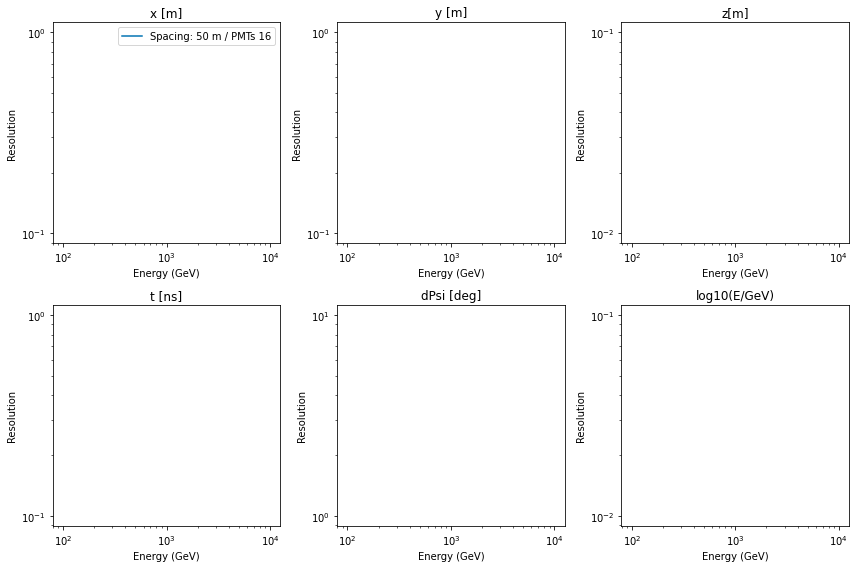

In [ ]:

fig, axs = plt.subplots(2, 3, figsize=(3*4, 2*4))

grouped = cr_df.groupby(level=[0, 2])

spacings = list(cr_df.groupby(level=0).groups.keys())

colors = sns.color_palette("colorblind", len(spacings))
color_map = {spacing : colors[i] for i, spacing in enumerate(spacings)}


for pv, ax, vn in zip(plot_vars, axs.ravel(), label_names):
    for (groupn, group) in grouped:
        energies = group.index.get_level_values(1)
        if (groupn[1] != 16):
            continue

        color = color_map[groupn[0]]
         
        if groupn[1] == 16:
            ls = "-"
        else:
            ls = "--" 

        baseline = cr_df.loc[50, :, 16][pv].values

        masked = np.isfinite(group[pv])

        ax.plot(energies[masked], group[pv][masked], label=f"Spacing: {groupn[0]:.0f} m / PMTs {groupn[1]:.0f}", color=color, ls=ls)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(vn)
    ax.set_xlabel("Energy (GeV)")
    ax.set_ylabel("Resolution")
plt.tight_layout()
axs[0][0].legend()

plt.savefig(f"figures/em_casc_edep_res{plot_tag}.png", dpi=150)


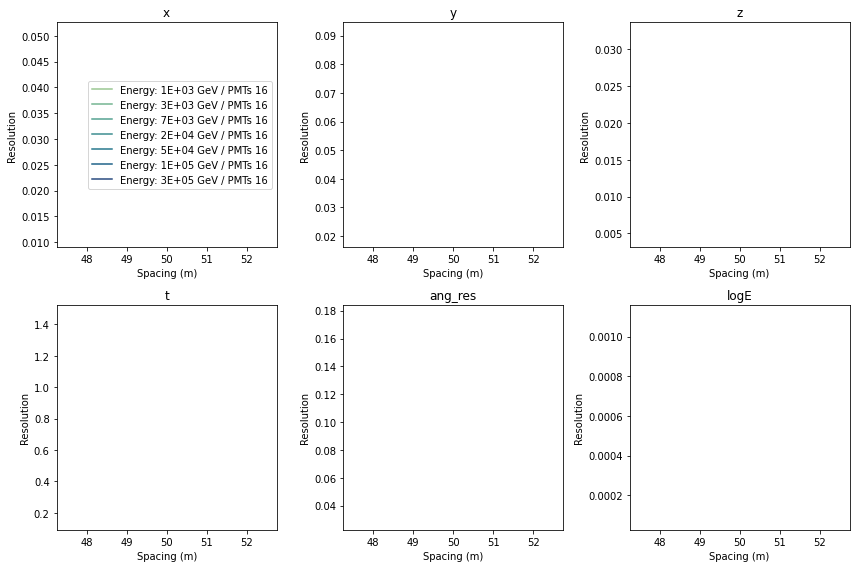

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(3*4, 2*4))

grouped = cr_df.groupby(level=[1, 2])

colors = sns.color_palette("crest", len(grouped))


for pv, ax in zip(plot_vars, axs.ravel()):
    for (groupn, group), color in zip(grouped, colors):
        spacing = group.index.get_level_values(0)
        if groupn[1] != 16:
            continue
        #baseline = cr_df.loc[50, :, 16][pv].values
        masked = np.isfinite(group[pv])
        ax.plot(spacing[masked], group[pv][masked], label=f"Energy: {groupn[0]:.0E} GeV / PMTs {groupn[1]:.0f}", color=color)
   
    ax.set_title(pv)
    ax.set_xlabel("Spacing (m)")
    ax.set_ylabel("Resolution")
axs[0][0].legend()
plt.tight_layout()
plt.savefig(f"figures/em_casc_spacingdep_res{plot_tag}.png", dpi=150)


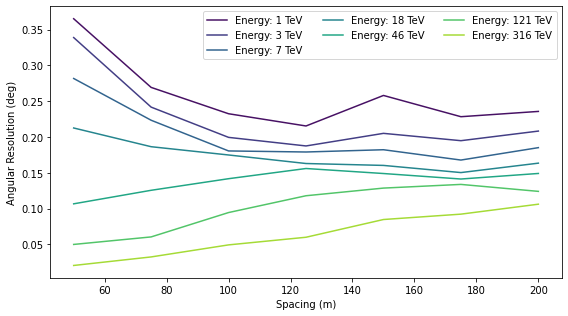

In [ ]:
fig, ax = plt.subplots(figsize=(16/2, 9/2))
grouped = cr_df.groupby(level=[1, 2])

colors = sns.color_palette("viridis", len(grouped))

for (groupn, group), color in zip(grouped, colors):
    spacing = group.index.get_level_values(0)
    if groupn[1] != 16:
        continue
    #baseline = cr_df.loc[50, :, 16][pv].values
    ax.plot(spacing, group["ang_res"], label=f"Energy: {groupn[0] / 1000:.0f} TeV", color=color)
   
#ax.set_title("Angular Resolution (deg)")
ax.set_xlabel("Spacing (m)")
ax.set_ylabel("Angular Resolution (deg)")
ax.legend(ncol=3)
#axs[0][0].legend()
plt.tight_layout()
plt.savefig("figures/em_casc_spacingdep_angres.png", dpi=150)

array([  1000.        ,   2610.15721568,   6812.92069058,  17782.79410039,
        46415.88833613, 121152.76586286, 316227.76601684])

In [ ]:
df["rho"] = df.position.apply(lambda s: np.sqrt(s[0]**2 + s[1]**2))
dfsel = df[(df.spacing==50) & (df.energy==np.unique(df.energy)[0]) & (df.pmts==16)]
dfsel = dfsel.set_index("rho")

varnames = ["x", "y", "z", "theta", "phi", "t", "logE"]
def inv_fisher(series):
    stacked = np.stack(series.values, axis=0)
    inv = np.linalg.inv(stacked)
    return inv

def cramer_rao_std(series):    
    cr = np.diag(np.sqrt(np.average(series, axis=0)))
    return cr

cr = dfsel.groupby(level=0).fisher.agg(inv_fisher).agg(cramer_rao_std)
stacked = np.vstack(cr.values)
cr_df = pd.DataFrame({varnames[i]: stacked[:, i] for i in range(len(varnames))}, index=cr.index)
cr_df["theta_deg"] = np.degrees(cr_df["theta"])
cr_df["phi_deg"] = np.degrees(cr_df["phi"])

cr_df["ang_res"] = np.degrees(np.sqrt(cr_df["phi"]**2 + cr_df["theta"]**2))



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='rho', ylabel='ang_res'>

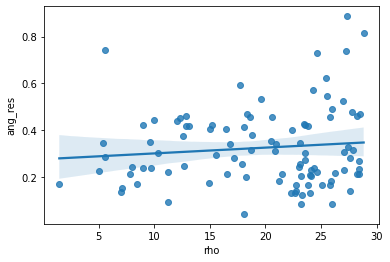

In [ ]:
sns.regplot(cr_df.index, cr_df["ang_res"])

In [ ]:
varnames = ["x", "y", "z", "theta", "phi", "t", "logE"]
def inv_fisher(series):
    stacked = np.stack(series.values, axis=0)
    inv = np.linalg.inv(stacked)
    return inv

def cramer_rao_std(series):    
    cr = np.diag(np.sqrt(np.average(series, axis=0)))
    return cr

cr = df.groupby(["spacing", "energy", "pmts"]).fisher.agg(inv_fisher).agg(cramer_rao_std)
stacked = np.vstack(cr.values)
cr_df = pd.DataFrame({varnames[i]: stacked[:, i] for i in range(len(varnames))}, index=cr.index)
cr_df["theta_deg"] = np.degrees(cr_df["theta"])
cr_df["phi_deg"] = np.degrees(cr_df["phi"])

cr_df["ang_res"] = np.degrees(np.sqrt(cr_df["phi"]**2 + cr_df["theta"]**2))

